# Number density and bias with real data

In [31]:
import os, sys, scipy
import esutil
import healpy as hp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
sys.path.append('../code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color_elg, assignELGProb, doVisualization_1d, XD_fitting_X
from run_DMASS_Y3 import priorCut_elg
#from systematics import *

# Loading Catalogs

Lading Y3 Gold catalog

In [38]:
#loading y3 gold catalogs
input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_keyword = 'Y3_GOLD_2_0_STRIPE82_00000'
columns = \
['RA', 'DEC', 'HPIX_4096', 
'COADD_OBJECT_ID', 
'EBV_SFD98',
'MOF_CM_MAG_CORRECTED_G',
'MOF_CM_MAG_CORRECTED_R',
'MOF_CM_MAG_CORRECTED_I',
'MOF_CM_MAG_CORRECTED_Z',
'MOF_CM_MAG_ERR_G',
'MOF_CM_MAG_ERR_R',
'MOF_CM_MAG_ERR_I',
'MOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)
mask_magcut = priorCut_elg(gold_st82)
gold_st82 = gold_st82[mask_magcut]


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000001.fits
Y3_GOLD_2_0_STRIPE82_000002.fits
Y3_GOLD_2_0_STRIPE82_000003.fits
Y3_GOLD_2_0_STRIPE82_000004.fits
Y3_GOLD_2_0_STRIPE82_000005.fits
Y3_GOLD_2_0_STRIPE82_000006.fits
Y3_GOLD_2_0_STRIPE82_000007.fits
Y3_GOLD_2_0_STRIPE82_000008.fits
Y3_GOLD_2_0_STRIPE82_000009.fits
reading 1/9 /n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/Y3_GOLD_2_0_STRIPE82_000001.fits
reading 2/9 /n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/Y3_GOLD_2_0_STRIPE82_000002.fits
reading 3/9 /n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/Y3_GOLD_2_0_STRIPE82_000003.fits
reading 4/9 /n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/Y3_GOLD_2_0_STRIPE82_000004.fits
reading 5/9 /n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/Y3_GOLD_2_0_STRIPE82_000005.fits
reading 6/9 /n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1

ValueError: no field of name SOF_CM_MAG_CORRECTED_G

Loading eBOSS sample

In [163]:
filename = '/n/des/lee.5922/data/eboss_cat/eBOSS_ELG_full_ALLdata-vDR16.fits'
#filename = '/n/des/lee.5922/data/eboss_cat/eBOSS_ELG_clustering_data-SGC-vDR16.fits'
elg = esutil.io.read(filename)

# Add healpix index to ELG catalog
healConfig = {'map_inside':4096,
              'out_nside':4096,
              'nest':False}
elg = HealPixifyCatalogs(catalog=elg, healConfig=healConfig, ratag='RA', dectag = 'DEC')

Calling Y3 GOLD footprint map 

In [164]:
# matching GOLD and ELG galaxies positions to find the ELG couterparts in GOLD
mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                     gold_st82['DEC'],2./3600, maxmatch=1)
clean_elg_data_sdss = train_sample[mg1]
clean_elg_data_des = gold_st82[mg2]
elg_mask = np.zeros(gold_st82.size, dtype=bool)
elg_mask[mg2] = 1
#clean_elg_data_des = gold_st82[elg_mask]
noelg = gold_st82[~elg_mask]

In [165]:
# save training samples
outdir = '../output/test_elg/train_cat/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'train_sample_des.fits', clean_elg_data_des, clobber=True)
esutil.io.write( outdir+'train_sample_sdss.fits', clean_elg_data_sdss, clobber=True)
esutil.io.write( outdir+'train_no_sample_des.fits', noelg, clobber=True)

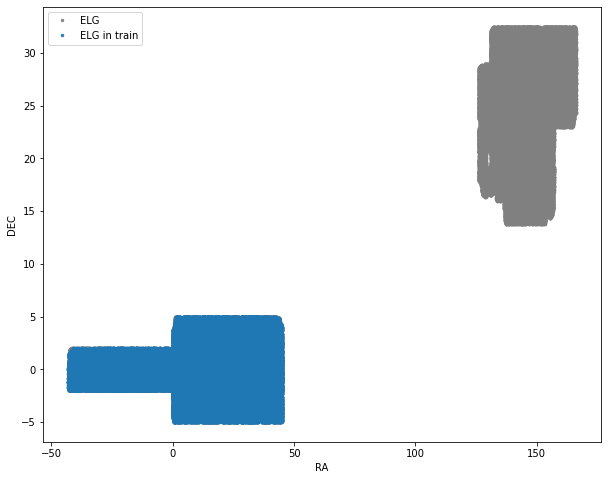

In [166]:
# Plotting footprint
spatialcheck([elg, clean_elg_data_des], 
             label = ['ELG', 'ELG in train'], convert = None, ratag='RA',dectag='DEC')

In [14]:
rootdir = '../output/test_elg_2/'

In [11]:
# save training samples
outdir = rootdir+'/train_cat/'
clean_elg_data_des = esutil.io.read( outdir+'train_sample_des.fits')
noelg = esutil.io.read( outdir+'train_no_sample_des.fits')
gold_st82 = np.hstack([clean_elg_data_des, noelg])

In [23]:
# Draw a random sample from the training sample to reduce the sample size for a fast run
# Put sample size you want 
n_sample =  int(clean_elg_data_des.size/2)  # train cmass sample size
n_sample_non = int(noelg.size/500)          # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_elg_data_des.size), size = n_sample)
clean_elg_data_des_sub = clean_elg_data_des[sampling_ind]
print('num of randomly sampled elg ', clean_elg_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(noelg.size), size = n_sample_non )
noelg_sub = noelg[random_sampling_ind]
print('num of randomly sampled non-elg ', noelg_sub.size)
elg_fraction = clean_elg_data_des.size *1./(clean_elg_data_des.size + noelg.size)
print('elg_fraction (elg/non-cmass): ', elg_fraction)

# save the fraction of ELG galaxies in the training sample
# This number will be called and used when assigning the ELG probability to GOLD galaxies. 
outdir = rootdir+'/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'elgfrac', 'w')
f.write('{:0.10f}'.format(elg_fraction))
f.close()

random sampling... 
num of randomly sampled elg  66554
num of randomly sampled non-elg  47596
elg_fraction (elg/non-cmass):  0.005562166420550828


# Comparison of colors 

NameError: name 'clean_elg_data_sdss' is not defined

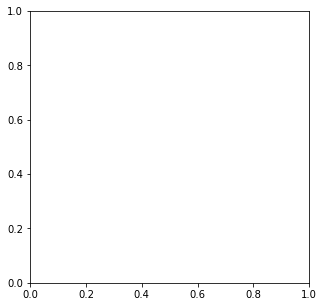

In [17]:
fig, ax =plt.subplots(figsize=(5,5))
ax.plot( clean_elg_data_sdss['g'], clean_elg_data_des['SOF_CM_MAG_CORRECTED_G'], '.', alpha=0.1  )
ax.plot( np.linspace(0,25,10), np.linspace(0,25,10), 'k--' )

ax.set_ylabel('des mag g')
ax.set_xlabel('eboss mag g')
ax.set_xlim(21.8, 22.8)
ax.set_ylim(21.8, 22.8)


fig, ax =plt.subplots(figsize=(5,5))
des_gr = clean_elg_data_des['SOF_CM_MAG_CORRECTED_G'] - clean_elg_data_des['SOF_CM_MAG_CORRECTED_R']
des_rz = clean_elg_data_des['SOF_CM_MAG_CORRECTED_R'] - clean_elg_data_des['SOF_CM_MAG_CORRECTED_Z']
ax.plot( clean_elg_data_sdss['gr'], des_gr, '.', label='g-r', alpha =0.1  )
ax.plot( clean_elg_data_sdss['rz'], des_rz, '.', label='r-z', alpha=0.1  )
ax.plot( np.linspace(0,2,10), np.linspace(0,2,10), 'k--' )

ax.set_ylabel('des color')
ax.set_xlabel('eboss color')
ax.set_xlim(0.2, 1.5)
ax.set_ylim(0.2, 1.5)
ax.legend()


fig, ax =plt.subplots(1,2, figsize=(10,5))
des_gr = clean_elg_data_des['SOF_CM_MAG_CORRECTED_G'] - clean_elg_data_des['SOF_CM_MAG_CORRECTED_R']
des_rz = clean_elg_data_des['SOF_CM_MAG_CORRECTED_R'] - clean_elg_data_des['SOF_CM_MAG_CORRECTED_Z']

eboss_gr = clean_elg_data_sdss['gr']
eboss_rz = clean_elg_data_sdss['rz']
ax[0].plot( eboss_gr, eboss_rz, '.', label='eBOSS', alpha =0.1  )
ax[1].plot( des_gr, des_rz, '.', label='DES Y3 GOLD', alpha =0.1  )

#ax.plot( np.linspace(0,2,10), np.linspace(0,2,10), 'k--' )

gr = np.linspace(0, 1, 10)
rz1 = 0.218 * gr + 0.571
rz2 = -0.555 * gr + 1.901
rz3 = 1./(-0.068) * (gr-0.457)
rz4 = 1./(0.112) * (gr-0.773)

for i in range(2):
    ax[i].plot(gr, rz1, 'k--')
    ax[i].plot(gr, rz2, 'k--')
    ax[i].plot(gr, rz3, 'k--')
    ax[i].plot(gr, rz4, 'k--')
    ax[i].set_ylabel('g-r')
    ax[i].set_xlabel('r-z')
    
    ax[i].set_xlim(0.2, 1.0)
    ax[i].set_ylim(0.3, 2.0)
    ax[i].legend(loc=1)

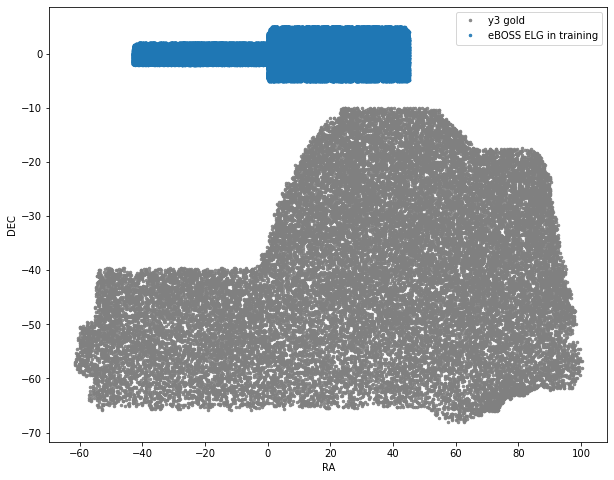

In [173]:
# Plotting footprint
#y3goldsam = esutil.io.read('/n/des/lee.5922/data/y3gold/Y3_GOLD_2_2_SPT_sam10_000001.fits')
y3goldsam = esutil.io.read('/n/des/lee.5922/data/y3gold/Y3_GOLD_2_2_SPT_sam100.fits')
randind=np.random.choice(y3goldsam.size, size=10000 )
spatialcheck([y3goldsam, clean_elg_data_des], 
             label = ['y3 gold', 'eBOSS ELG in training'], 
             convert = None, ratag='RA',dectag='DEC')

In [24]:
# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_elg_true, X_elg_cov = mixing_color_elg(clean_elg_data_des_sub, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=False)

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color_elg(noelg_sub, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=False)

Using central 98% to set range.


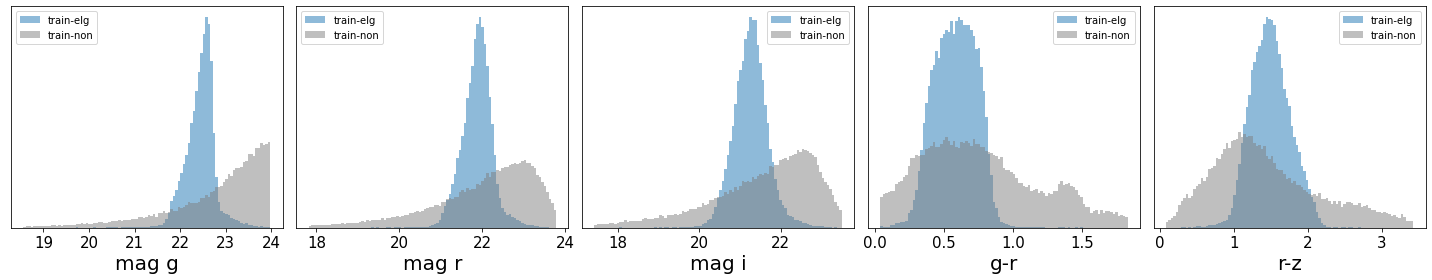

In [25]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
filename = 'figure/hist_color_elg.png'
doVisualization_1d(data=[X_elg_true, X_no_true], 
                   labels = ['mag g', 'mag r', 'mag i', 'g-r', 'r-z'], 
                   ranges = None, 
                   name = ['train-elg', 'train-non'], 
                   color= ['tab:blue', 'grey'],
                   weight = [None,None], 
                   nbins=100, filename=filename)

# Extreme Deconvolution Fitting

In [26]:
# number of gaussian mixtures
n_elg = None    # for fitting the cmass distributions
n_no = None       # for fitting the non-cmass distributions

# number of XD iteration. 
# I set this number small for a fast run but 
# should be run until the XD algorithm converges
n_iter_elg = 10
n_iter_no = 10
# tolerance
tol = 1E-5

# pickle filename
outdir = rootdir+'/fitting/'
os.makedirs(outdir, exist_ok=True)
elg_pickle = outdir+'gm_elg_Mgri_Cgr_rz.pkl'.format(n_elg)
no_pickle = outdir+'gm_no_Mgri_Cgr_rz.pkl'.format(n_no)

In [27]:
# XD Fitting. This will take a while 

mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I', 'Z']

clf_elg = XD_fitting_X( X = X_elg_true, Xcov = X_elg_cov, pickleFileName = elg_pickle, 
                       mag=mag, err=err, filter=filter, 
                       n_cl = n_elg, n_iter = n_iter_elg, tol = tol, 
                       verbose = True, init_params= None)                 
clf_no = XD_fitting_X( X = X_no_true, Xcov = X_no_cov, pickleFileName = no_pickle, 
                    mag=mag, err=err, filter=filter, 
                    n_cl = n_no, n_iter = n_iter_no, tol = tol, 
                    verbose = True, init_params = None)

@pickle_results: computing results and saving to '../output/test_elg_2//fitting/gm_elg_Mgri_Cgr_rz.pkl'
@pickle_results: computing results and saving to '../output/test_elg_2//fitting/gm_elg_Mgri_Cgr_rz.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  14


/n/des/lee.5922/programs/anaconda3/envs/env_py3/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


n components = 14
tolerance = 1e-05
1: log(L) = 210878.7038
    (21 sec)
2: log(L) = 211535.1546
    (22 sec)
3: log(L) = 211941.8437
    (22 sec)
4: log(L) = 212239.744
    (22 sec)
5: log(L) = 212475.6286
    (21 sec)
6: log(L) = 212671.6269
    (21 sec)
7: log(L) = 212840.0948
    (21 sec)
8: log(L) = 212988.5504
    (22 sec)
9: log(L) = 213121.762
    (21 sec)
10: log(L) = 213242.8005
    (22 sec)
elapsed time: 3.26 min,  total iteration 9                                 
@pickle_results: computing results and saving to '../output/test_elg_2//fitting/gm_no_Mgri_Cgr_rz.pkl'
@pickle_results: computing results and saving to '../output/test_elg_2//fitting/gm_no_Mgri_Cgr_rz.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  36


/n/des/lee.5922/programs/anaconda3/envs/env_py3/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


n components = 36
tolerance = 1e-05
1: log(L) = 29928.30913
    (35 sec)
2: log(L) = 30880.6446
    (36 sec)
3: log(L) = 31443.64394
    (36 sec)
4: log(L) = 31839.43787
    (36 sec)
5: log(L) = 32144.43536
    (41 sec)
6: log(L) = 32392.97758
    (40 sec)
7: log(L) = 32604.24564
    (38 sec)
8: log(L) = 32789.94391
    (44 sec)
9: log(L) = 32958.66683
    (46 sec)
10: log(L) = 33118.87549
    (47 sec)
elapsed time: 7.03 min,  total iteration 9                                 


In [302]:
# callig saved pickles 
clf_cmass = XD_fitting_X( None, None, pickleFileName = elg_pickle)               
clf_no = XD_fitting_X( None, None, pickleFileName = no_pickle)

In [308]:
# Drawing random samples from the fitted Gaussian mixture model
# If the model is correct, the random sample should match with the training sample
X_sample_elg = clf_elg.sample(100000)  # cmass model
X_sample_no = clf_no.sample(100000)        # non-cmass model

Using central 98% to set range.
T-test:
Ttest_indResult(statistic=0.41191934471806557, pvalue=0.6803993205605928)
Ttest_indResult(statistic=0.5674894882594679, pvalue=0.5703827906588609)
Ttest_indResult(statistic=0.40644012861495316, pvalue=0.6844200073771961)
Ttest_indResult(statistic=-0.5687676865726176, pvalue=0.5695149336610477)
Ttest_indResult(statistic=579.6009903115356, pvalue=0.0)

KS-test:
KstestResult(statistic=0.018552539444027127, pvalue=0.000607446902234883)
KstestResult(statistic=0.007450924117205049, pvalue=0.5294256390849014)
KstestResult(statistic=0.006068835462058608, pvalue=0.7774816056236518)
KstestResult(statistic=0.03193126972201343, pvalue=7.695907740411025e-11)
KstestResult(statistic=0.9826371224643126, pvalue=0.0)


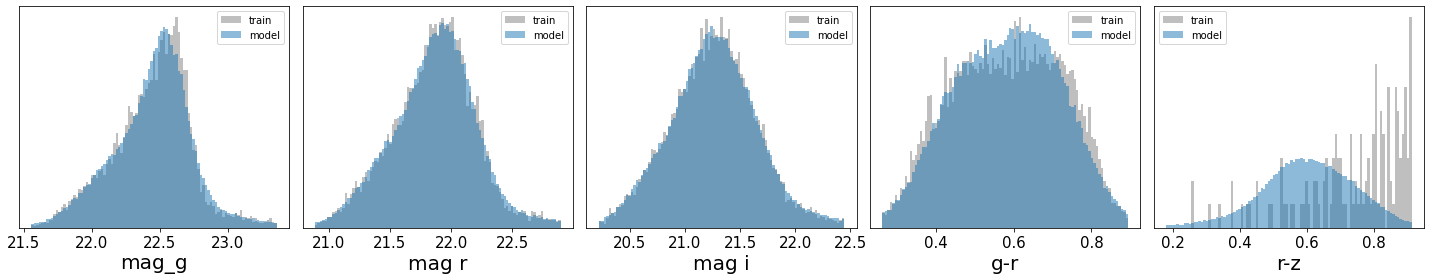

In [309]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
filename = 'figure/test.png'
doVisualization_1d( data=[X_elg_true, X_sample_elg], 
                   labels = ['mag_g', 'mag r', 'mag i', 'g-r', 'r-z'], 
                   ranges = None, 
                   name = ['train', 'model'], 
                   weight = [None,None], 
                   nbins=100, filename=filename)

# Statistical significance tests
print ('T-test:')
for i in range(X_elg_true.shape[1]):
    res = scipy.stats.ttest_ind(X_elg_true[:,i], X_sample_elg[:,i])
    print(res)
print ('\nKS-test:')
for i in range(X_elg_true.shape[1]):
    res = scipy.stats.ks_2samp(X_elg_true[:,i], X_sample_elg[:,i])
    print (res)

Using central 98% to set range.
T-test:
Ttest_indResult(statistic=0.5572188713985159, pvalue=0.5773787426078316)
Ttest_indResult(statistic=0.45549793104322966, pvalue=0.6487517257675359)
Ttest_indResult(statistic=0.37547366855368225, pvalue=0.7073087654022951)
Ttest_indResult(statistic=0.1336364404261066, pvalue=0.8936902495317975)
Ttest_indResult(statistic=0.30363385440234303, pvalue=0.7614072844376578)
Ttest_indResult(statistic=-9.571053273483468, pvalue=1.0736941137993888e-21)
Ttest_indResult(statistic=-3.2904936452521563, pvalue=0.0010003519555469515)

KS-test:
KstestResult(statistic=0.029903386839230106, pvalue=1.7426752850182571e-25)
KstestResult(statistic=0.006192622909488188, pvalue=0.1678255096782324)
KstestResult(statistic=0.004294412975880291, pvalue=0.5901381925587472)
KstestResult(statistic=0.020624411295066813, pvalue=2.3975211809376365e-12)
KstestResult(statistic=0.03345865366837551, pvalue=8.467556016541725e-32)
KstestResult(statistic=0.05739244306244223, pvalue=9.06707

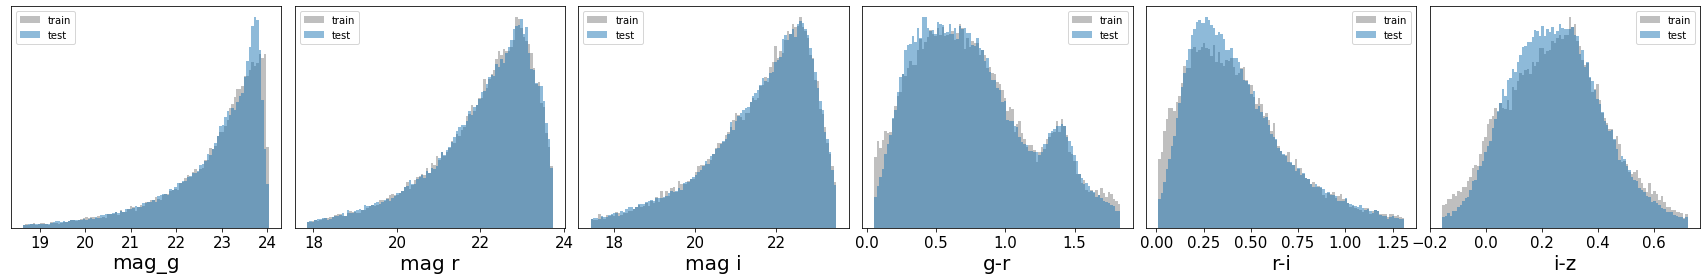

In [281]:
# Comparison. train vs. randoms for non-cmass
filename = 'figure/test.png'
doVisualization_1d( data=[X_no_true, X_sample_no], 
                   labels = ['mag_g', 'mag r', 'mag i', 'g-r', 'r-i', 'i-z'], 
                   ranges = None, 
                   name = ['train', 'test'], 
                   weight = [None,None], 
                   nbins=100, filename=filename)

# Statistical significance tests
print ('T-test:')
for i in range(X_elg_true.shape[1]):
    res = scipy.stats.ttest_ind(X_no_true[:,i], X_sample_no[:,i])
    print(res)
print ('\nKS-test:')
for i in range(X_elg_true.shape[1]):
    res = scipy.stats.ks_2samp(X_no_true[:,i], X_sample_no[:,i])
    print (res)

In [282]:

mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I', 'Z']

rand_ind = np.random.choice(gold_st82.size, size = 1000000)

# Assigning CMASS probabilities to Gold Y3 in Stripe 82.
# The probabilities are saved to 'CMASS_PROB' column 
gold_st82_test = assignELGProb(gold_st82[rand_ind], clf_elg, clf_no, 
                     cmass_fraction = elg_fraction, 
                     mag=mag, err=err, filter=filter, full=True )

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


In [ ]:
#outdir = '../output/test_elg/test_cat/'
#esutil.io.write(outdir+'DeBOSS_ELG_ra10_20_decm40_m30.fits', gold_spt_prob, clobber=True)

In [283]:
# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_elg_true, Xcov = mixing_color_elg(clean_elg_data_des, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=True)

In [284]:
# Generate Four columns of data : mag r, mag i, (g-r), (r-i)
X_delg_st82, Xcov = mixing_color_elg(gold_st82_test, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=True )

In [288]:
X_elg_true[:,i].shape

(133109,)

Using central 98% to set range.
(16.82138744787351, 1.9656434819139995e-63)
(14.090138138779615, 4.6900244890886405e-45)
(12.198786166280923, 3.284419227592763e-34)
(2.776827431649648, 0.005489964230842643)
(1.6609907152622607, 0.09671756083706097)
(-10.906159771218322, 1.1052477064295707e-27)
(-3.0549622687268028, 0.002251313364719808)
KstestResult(statistic=0.5484766414517426, pvalue=0.0)
KstestResult(statistic=0.4178434225634631, pvalue=0.0)
KstestResult(statistic=0.4303811825571524, pvalue=0.0)
KstestResult(statistic=0.3684057688811425, pvalue=0.0)
KstestResult(statistic=0.4364184201443929, pvalue=0.0)
KstestResult(statistic=0.26113391023146443, pvalue=0.0)
KstestResult(statistic=0.3067915419242876, pvalue=0.0)


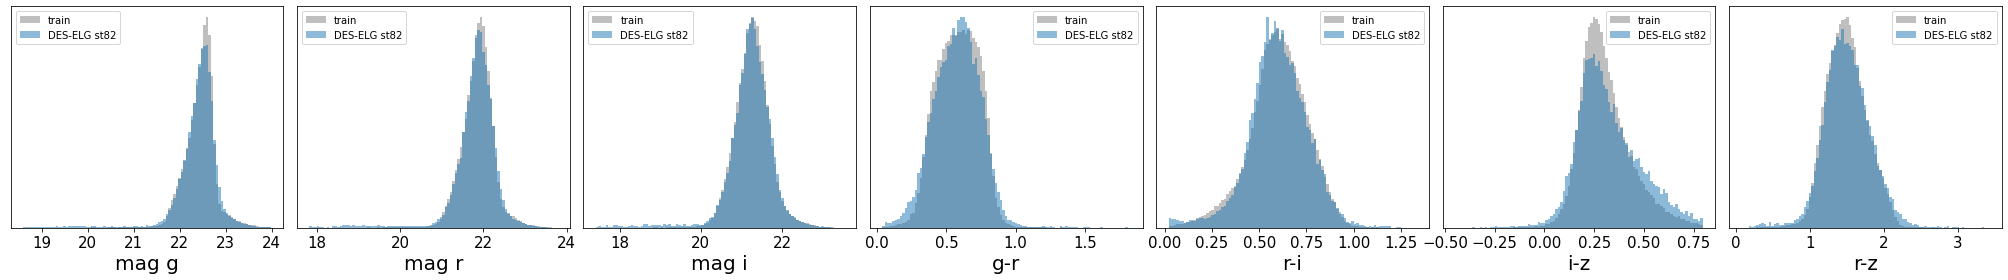

In [289]:
# Comparison plot for the training sample (cmass) vs. dmass sample 
# DMASS sample should be weighted by 'CMASS_PROB' column when plotting
filename = 'figure/hist_color_elg.png'
weight_elg = gold_st82_test['ELG_PROB']
doVisualization_1d( data=[X_elg_true, X_delg_st82], 
                   weight = [None, weight_elg],
                   labels = ['mag g', 'mag r', 'mag i', 'g-r', 'r-i', 'i-z', 'r-z'], 
                   #labels = ['mag g', 'mag r', 'mag i', 'g-r', 'r-z'], 
                   ranges = None, 
                   name = ['train', 'DES-ELG st82'], 
                   nbins=100, filename=filename)

# Statistical significance tests
from statsmodels.stats.weightstats import ttest_ind
for i in range(X_elg_true.shape[1]):
    res = ttest_ind(X_elg_true[:,i], X_delg_st82[:,i], weights=(None, weight_elg))
    print(res[:-1])
for i in range(X_elg_true.shape[1]):
    #KS test should be weighted (not weighted here)
    res = scipy.stats.ks_2samp(X_elg_true[:,i], X_delg_st82[:,i])
    print (res)

# Outside training region

Repeat for Y3 GOLD galaxies that are not in Stripe 82

In [231]:
# callig saved pickles 

outdir = '../output/test_elg/fitting/'
os.makedirs(outdir, exist_ok=True)
elg_pickle = outdir+'gm_elg_Mgri_Cgriz.pkl'
no_pickle = outdir+'gm_no_Mgri_Cgriz.pkl'
f = open(outdir+'elgfrac', 'r')
elg_fraction = float(f.readline())

clf_elg = XD_fitting_X( None, None, pickleFileName = elg_pickle)               
clf_no = XD_fitting_X( None, None, pickleFileName = no_pickle)

In [7]:
outdir = '../output/test_elg/train_cat/'
train_filename = outdir+'train_sample_des.fits'
clean_elg_data_des = esutil.io.read(train_filename)

In [291]:
# Calling Y3 GOLD in a small square area 

# columns to call
columns = \
['RA', 'DEC', 'HPIX_4096', 
'COADD_OBJECT_ID', 
'EBV_SFD98',
'SOF_CM_MAG_CORRECTED_G',
'SOF_CM_MAG_CORRECTED_R',
'SOF_CM_MAG_CORRECTED_I',
'SOF_CM_MAG_CORRECTED_Z',
'SOF_CM_MAG_ERR_G',
'SOF_CM_MAG_ERR_R',
'SOF_CM_MAG_ERR_I',
'SOF_CM_MAG_ERR_Z']
# Y3 Gold (SPT) catalog directory
input_path = '/n/des/lee.5922/data/gold_cat_Y3/SPT/701615bf64824498972491d545d1e4df/'

# magnitudes and corresponding error columns that will be used
# to assign the DMASS (ELG) probability
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I', 'Z']

# directory to save
outdir = '../output/test_elg/test_cat_Mgri_Cgriz/'
os.makedirs(outdir, exist_ok=True)

# Y3 GOLD catalog is too large to load all at once. 
# I split the catalog into 17 chuncks and load one by one 
# to assign the DMASS(ELG) probability 
for i in range(1,18):
    # catalog name
    input_keyword = 'Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_0000{:02.0f}.fits'.format(i)
    gold_spt_i = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)
    gold_spt_i = gold_spt_i[priorCut_elg(gold_spt_i)]
    
    # assign probability
    gold_spt_prob_i = assignELGProb(gold_spt_i, clf_elg, clf_no, 
                     cmass_fraction = elg_fraction, 
                     mag=mag, err=err, filter=filter, full=True )
    
    # save fitsfile
    fitsname = 'DeBOSS_ELG_'+input_keyword
    print ('save to ', fitsname)
    esutil.io.write(outdir+fitsname, gold_spt_prob_i)
    
    # empty memory
    gold_spt_i, gold_spt_prob_i = None, None


Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits
reading 1/1 /n/des/lee.5922/data/gold_cat_Y3/SPT/701615bf64824498972491d545d1e4df/Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits
reading 1/1 /n/des/lee.5922/data/gold_cat_Y3/SPT/701615bf64824498972491d545d1e4df/Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
save to  DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits

Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits
reading 1/1 /n/des/lee.5922/data/gold_cat_Y3/SPT/701615bf64824498972491d545d1e4df/Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
save to  DeBOSS_ELG_

In [4]:
# calling the final catalog 
input_path = '../output/test_elg/test_cat/'
input_keyword = 'Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000'
gold_spt_prob = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=None)
#gold_spt_prob = gold_spt_prob[priorCut_elg(gold_spt_prob)]


Calling catalogs >>>
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000005.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000007.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000008.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000009.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000010.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000011.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000012.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000013.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000014.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000015.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000016.fits
DeBOSS_ELG_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_0000

In [292]:
X_delg, Xcov = mixing_color_elg(gold_spt_prob, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'],
                full = True  )
X_elg_true, X_elg_cov = mixing_color_elg(clean_elg_data_des, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I', 'Z'], full=True)

Using central 98% to set range.
(3.413881951722288, 0.0006406139160511165, 148709.79031407656)
(2.5999685479895045, 0.009324151995009371, 148709.79031407656)
(7.433004964527979, 1.0672360962936383e-13, 148709.79031407656)
(1.2447828984640552, 0.21321352567723267, 148709.79031407656)
(-15.025614358812907, 5.439719036972993e-51, 148709.79031407656)
(1.3567107813519304, 0.17487518488655238, 148709.79031407656)
(-7.149193433860362, 8.768829346765992e-13, 148709.79031407656)
KstestResult(statistic=0.5802903656404758, pvalue=0.0)
KstestResult(statistic=0.4475155005347788, pvalue=0.0)
KstestResult(statistic=0.4623501395994036, pvalue=0.0)
KstestResult(statistic=0.36132759217216603, pvalue=0.0)
KstestResult(statistic=0.45054361400697446, pvalue=0.0)
KstestResult(statistic=0.2679310947421198, pvalue=0.0)
KstestResult(statistic=0.3139674667296055, pvalue=0.0)


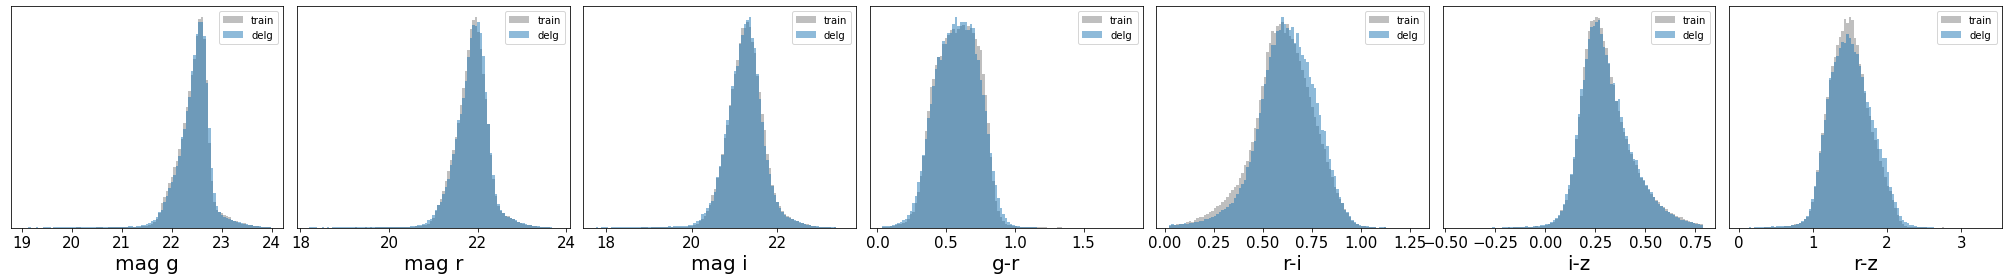

In [293]:
filename = 'figure/test.png'
weight_elg = gold_spt_prob['ELG_PROB']
doVisualization_1d(data=[X_elg_true, X_delg], 
                   weight = [None, weight_elg],
                   labels = ['mag g', 'mag r', 'mag i', 'g-r', 'r-i', 'i-z', 'r-z'], 
                   ranges = None, 
                   name = ['train', 'delg'], 
                   nbins=100, 
                   filename=filename)

# Statistical significance tests
from statsmodels.stats.weightstats import ttest_ind
for i in range(X_elg_true.shape[1]):
    res = ttest_ind(X_elg_true[:,i], X_delg[:,i], weights=(None, weight_elg))
    print(res)
for i in range(X_elg_true.shape[1]):
    #KS test should be weighted (not weighted here)
    res = scipy.stats.ks_2samp(X_elg_true[:,i], X_delg[:,i])
    print (res)

In [246]:
#outdir = '../output/test_elg/test_cat/'
#esutil.io.write(outdir+'DeBOSS_ELG_ra10_20_decm40_m30.fits', gold_spt_prob, clobber=True)

In [294]:
# compute number density
p01cut = gold_spt_prob['ELG_PROB'] > 0.01
ngal_elg = np.sum( gold_spt_prob['ELG_PROB'][p01cut])
ngal_total = gold_spt_prob.size
density = ngal_elg/ngal_total
print ('training sample number density: ', elg_fraction)
print ('ELG number density in GOLD Y3: ', density)

training sample number density:  0.0055621664
ELG number density in GOLD Y3:  0.006109054496397531


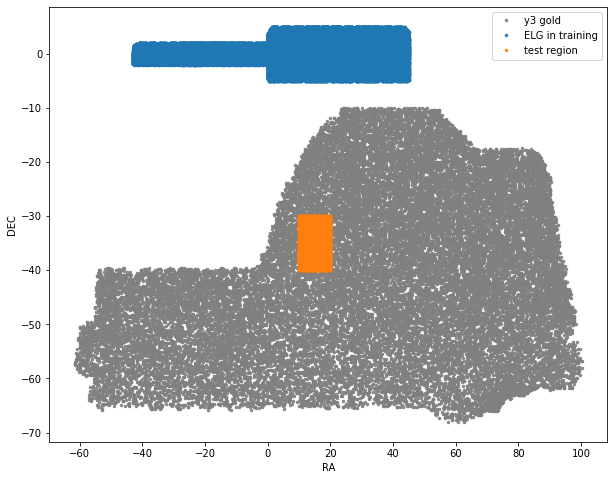

In [249]:
# Plotting footprint
#y3goldsam = esutil.io.read('/n/des/lee.5922/data/y3gold/Y3_GOLD_2_2_SPT_sam10_000001.fits')
y3goldsam = esutil.io.read('/n/des/lee.5922/data/y3gold/Y3_GOLD_2_2_SPT_sam100.fits')
randind=np.random.choice(y3goldsam.size, size=10000 )
randind_spt=np.random.choice(gold_spt_prob.size, size=10000 )
spatialcheck([y3goldsam, clean_elg_data_des,gold_spt_prob[randind_spt] ], 
             label = ['y3 gold', 'ELG in training', 'test region'], 
             convert = None, ratag='RA',dectag='DEC')